у нас есть урожайности фактическая и плановая. Можно посмотреть от чего зависит сальдо этих значений (буквально исследовательский вопрос: что влияет на неточность предсказаний урожайности?)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_fields = pd.read_csv('../data/fields.csv', delimiter=';', decimal=',', skiprows=[0, 2])
df_value = pd.read_csv('../data/value.csv', delimiter=';', decimal=',', skiprows=[0, 1], parse_dates=['inv_item_date'], date_format={'inv_item_date': '%d.%m.%Y'})
df_works = pd.read_csv('../data/works.csv', delimiter=';', decimal=',', skiprows=[0, 1], parse_dates=['start_date', 'end_date'], date_format={'start_date': '%d.%m.%Y', 'end_date': '%d.%m.%Y'})

df_works['area'] = df_works['area'].str.replace(',', '.').astype(float)

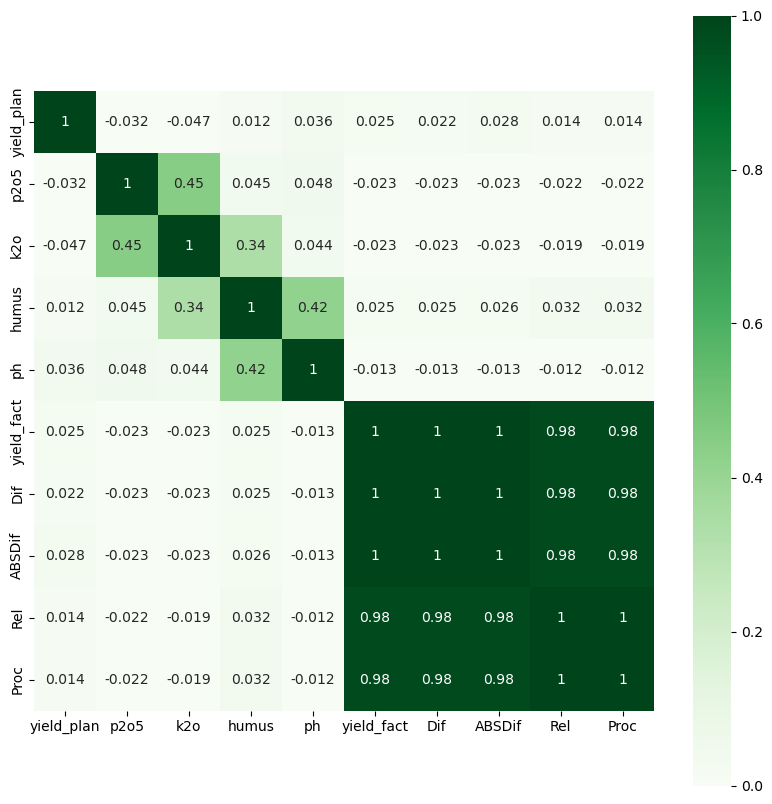

In [3]:
df = pd.read_csv('../data/Yeldmetrics.csv', delimiter=';', decimal=',', skiprows=[0, 2]).dropna()

plt.figure(figsize=(10, 10))

corrs = df.corr().round(3)
sns.heatmap(corrs,
            cmap = 'Greens',
            square=True,
            vmin = 0,
            annot=True)

plt.show()

In [4]:
valid_work_subtypes = ['Прямое комбайнирование', 'Подбор и обмолот', 'Заготовка сенажа', 'Уборка силос/карнаж', 'Подбор (корм)', 'Вывоз', 'Прессование']
valid_work_types = ['Обработка почвы', 'Уборка']

df_yield_fact_works = df_works.query(
    f"work_type in {valid_work_types} and work_subtype in {valid_work_subtypes}"
)[['season', 'field', 'yield_fact', 'area', 'work_type']]

df_yield_fact = (
    df_yield_fact_works
    .assign(weighted_yield=lambda x: x['yield_fact'] * x['area'])
    .groupby(['field', 'season'])
    .agg(weighted_yield=('weighted_yield', 'sum'), total_area=('area', 'sum'))
    .assign(weighted_mean=lambda x: x['weighted_yield'] / x['total_area'])
    .reset_index()[['field', 'season', 'weighted_mean']]
)

df_yield_fact = df_yield_fact.rename(columns={'weighted_mean': 'yield_fact'})

df_yield_fact.head()

,field,season,yield_fact
0,02.09.02.002.01,2023,1.568170
1,02.09.02.002.01,2024,0.000000
2,02.09.02.015.00,2023,1.223696
3,02.09.02.019.00,2023,2.150000
4,02.09.03.032.00,2023,268.696209


In [5]:
df_fields.shape

(16060, 19)

In [6]:
df_fields_tmp = df_fields[['season', 'field', 'p2o5', 'k2o', 'humus', 'ph', 'crop', 'region', 'yield_plan']]
df_fields_tmp.head()

df = df_fields_tmp.merge(df_yield_fact, how='left', on=['field', 'season']) #.dropna(subset=['yield_fact', 'yield_plan'])

df.head()

,season,field,p2o5,k2o,humus,ph,crop,region,yield_plan,yield_fact
0,2023,22.47.01.001.01,221.05,206.3,4.05,5.25,Оз.пшеница мягкая,Алтай,3.8,190.592405
1,2023,22.47.01.001.02,221.05,206.3,4.05,5.25,Пар,Алтай,NaN,NaN
2,2023,22.47.01.002.00,199.80,186.0,3.50,5.20,Пар,Алтай,NaN,NaN
3,2023,22.47.01.003.00,186.50,174.8,5.90,5.40,Оз.пшеница мягкая,Алтай,3.8,1.851617
4,2023,22.47.01.004.00,166.60,147.9,5.60,5.40,Оз.пшеница мягкая,Алтай,3.8,1.418186


In [7]:
df.shape

(16060, 10)

In [8]:
df.isna().sum()

season           0
field            0
p2o5          5750
k2o           5743
humus         5788
ph            5742
crop             0
region           0
yield_plan    5205
yield_fact    6573
dtype: int64

In [9]:
df = df.dropna()

In [10]:
df.shape

(7324, 10)

In [11]:
df['fact_plan_dif'] = df['yield_fact'] - df['yield_plan']
df['fact_plan_dif_abs'] = abs(df['fact_plan_dif'])
df['fact_plan_div'] = df['fact_plan_dif'] / df['yield_plan']
df['fact_plan_share_dif'] = df['yield_fact'] / df['yield_plan'] - 1

In [12]:
df.head()

,season,field,p2o5,k2o,humus,ph,crop,region,yield_plan,yield_fact,fact_plan_dif,fact_plan_dif_abs,fact_plan_div,fact_plan_share_dif
0,2023,22.47.01.001.01,221.05,206.3,4.05,5.25,Оз.пшеница мягкая,Алтай,3.8,190.592405,186.792405,186.792405,49.155896,49.155896
3,2023,22.47.01.003.00,186.50,174.8,5.90,5.40,Оз.пшеница мягкая,Алтай,3.8,1.851617,-1.948383,1.948383,-0.512732,-0.512732
4,2023,22.47.01.004.00,166.60,147.9,5.60,5.40,Оз.пшеница мягкая,Алтай,3.8,1.418186,-2.381814,2.381814,-0.626793,-0.626793
7,2023,22.47.01.006.02,194.70,195.9,4.00,5.15,Оз.пшеница мягкая,Алтай,3.8,2.187347,-1.612653,1.612653,-0.424382,-0.424382
9,2023,22.47.01.007.02,184.20,171.4,4.40,5.05,Оз.пшеница мягкая,Алтай,3.8,2.109071,-1.690929,1.690929,-0.444981,-0.444981


<Axes: >

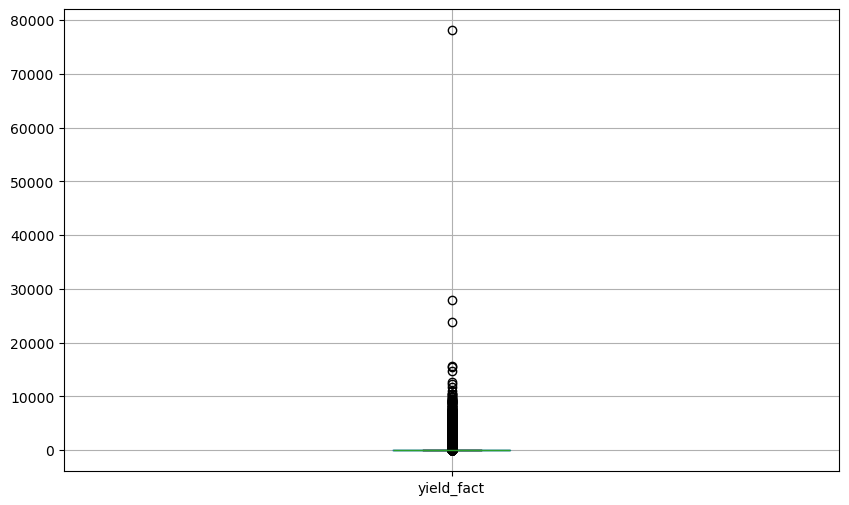

In [13]:
df.boxplot(column=['yield_fact'], figsize=(10, 6))

In [14]:
def remove_outliers_iqr(df, column, k = 1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [15]:
df = remove_outliers_iqr(df, 'yield_fact', k=1.5)

In [16]:
df.shape

(6759, 14)

<Axes: >

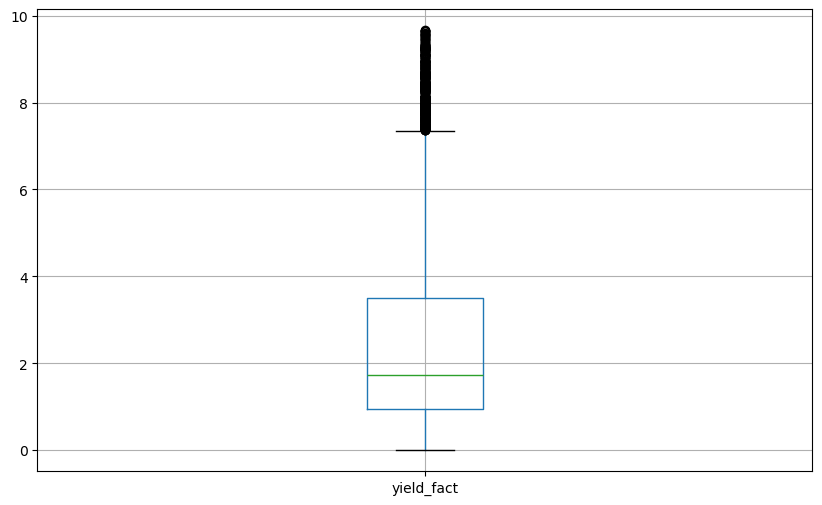

In [17]:
df.boxplot(column=['yield_fact'], figsize=(10, 6))

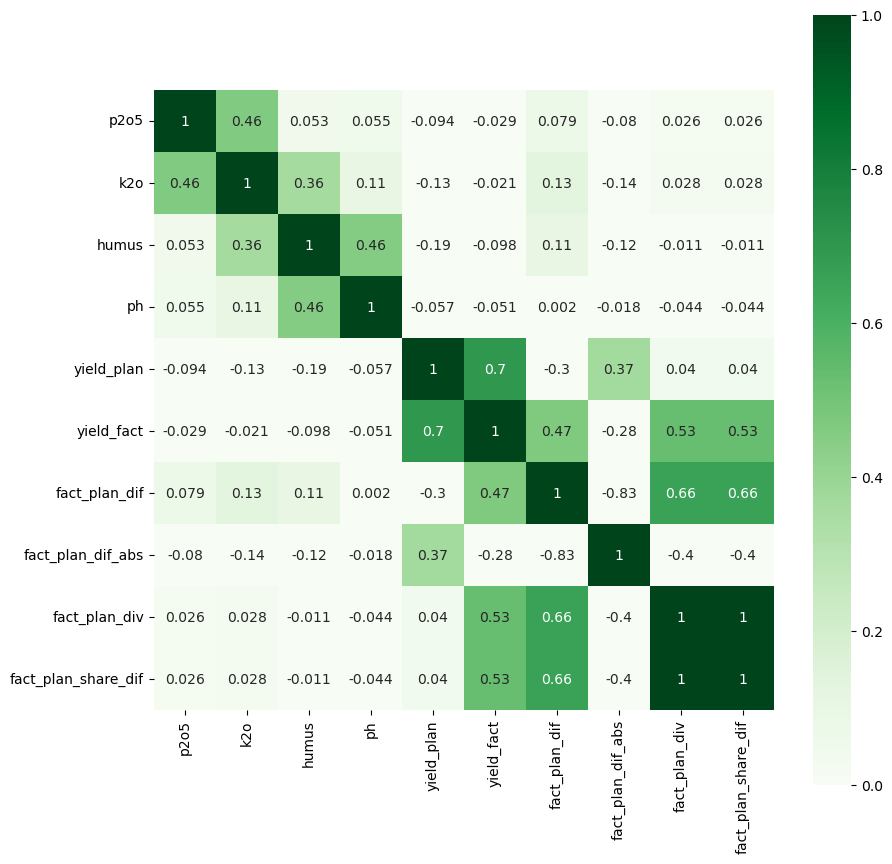

In [47]:
plt.figure(figsize=(10, 10))

corrs = df.drop(['season', 'field', 'crop', 'region'], axis=1).corr().round(3)
sns.heatmap(corrs,
            cmap = 'Greens',
            square=True,
            vmin = 0,
            annot=True)

plt.show()

In [48]:
top_crops = df['crop'].value_counts().head(5).index.to_list()
top_crops

['Кукуруза силос',
 'Люцерна пр.лет корм',
 'Оз.пшеница мягкая',
 'Соя',
 'Яр.пшеница мягкая']

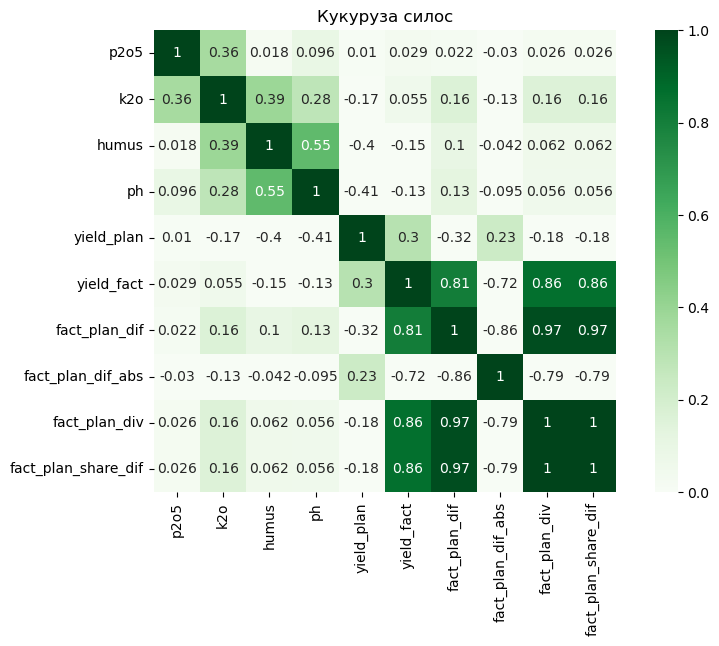

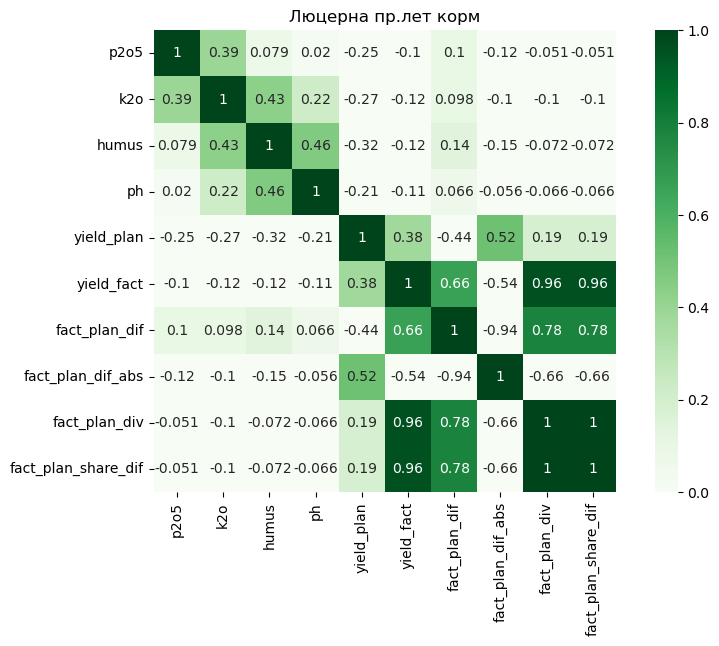

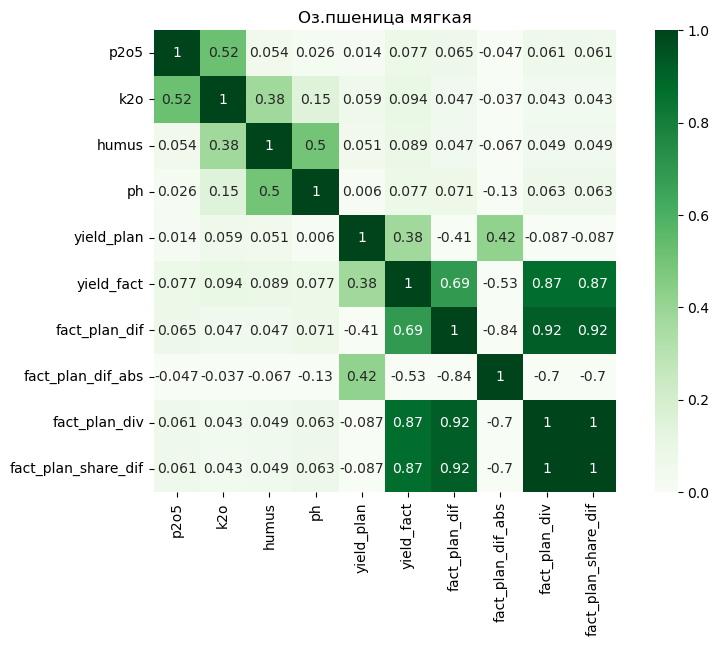

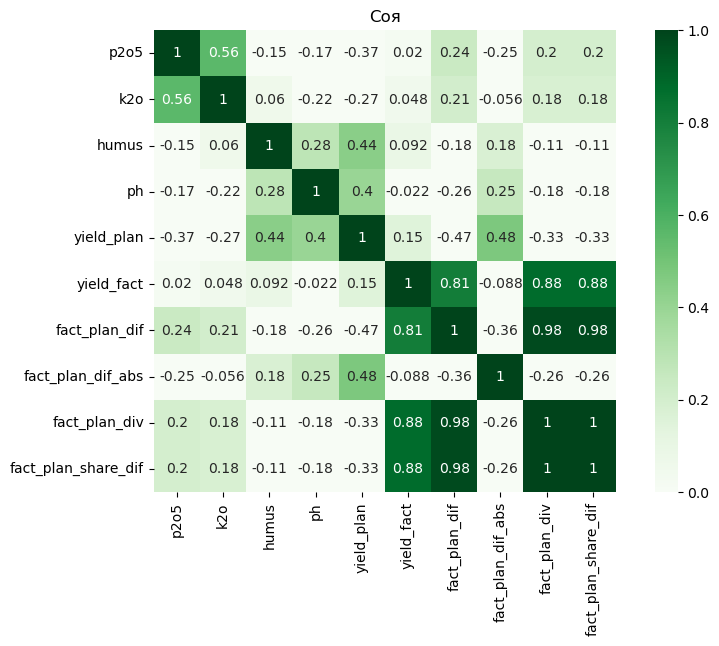

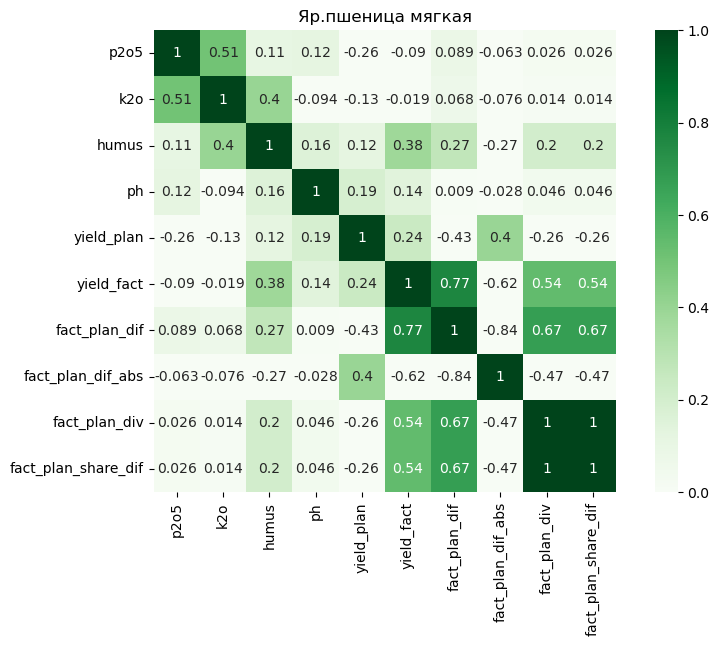

In [49]:
for crop in top_crops:
    plt.figure(figsize=(10, 6))

    df_crop = df.query(f"crop == '{crop}'")

    corrs = df_crop.drop(['season', 'field', 'crop', 'region'], axis=1).corr().round(3)
    sns.heatmap(corrs,
                cmap = 'Greens',
                square=True,
                vmin = 0,
                annot=True)

    plt.title(f'{crop}')
    plt.show()

plt.close()

In [50]:
top_regions = df['region'].value_counts().head(5).index.to_list()
top_regions

['Воронеж', 'Калуга', 'Рязань', 'Курск', 'Татарстан']

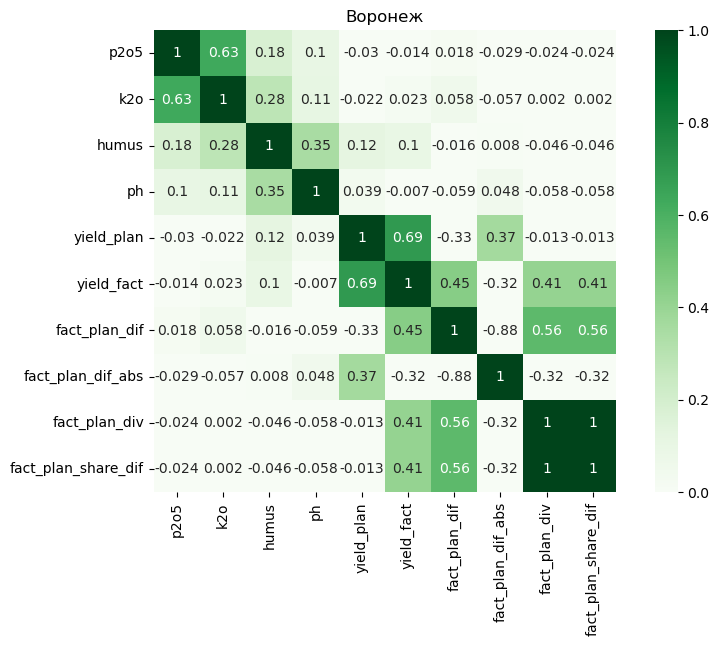

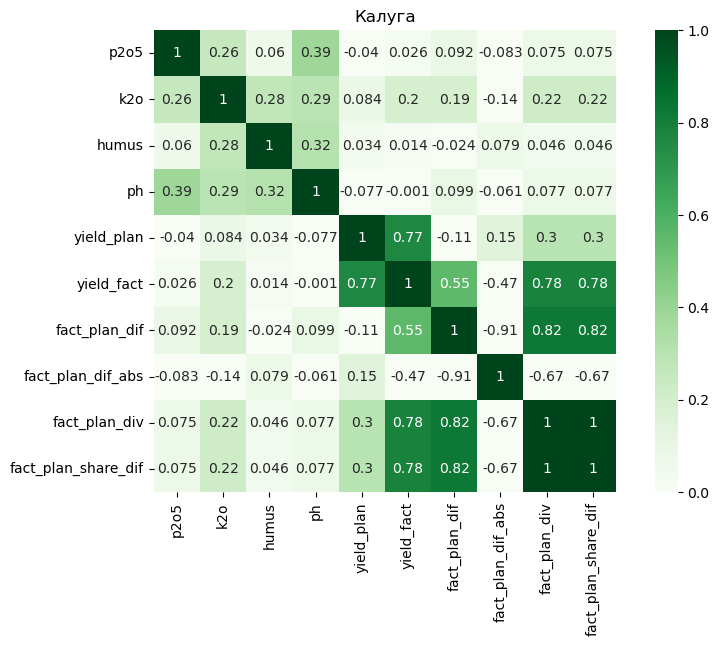

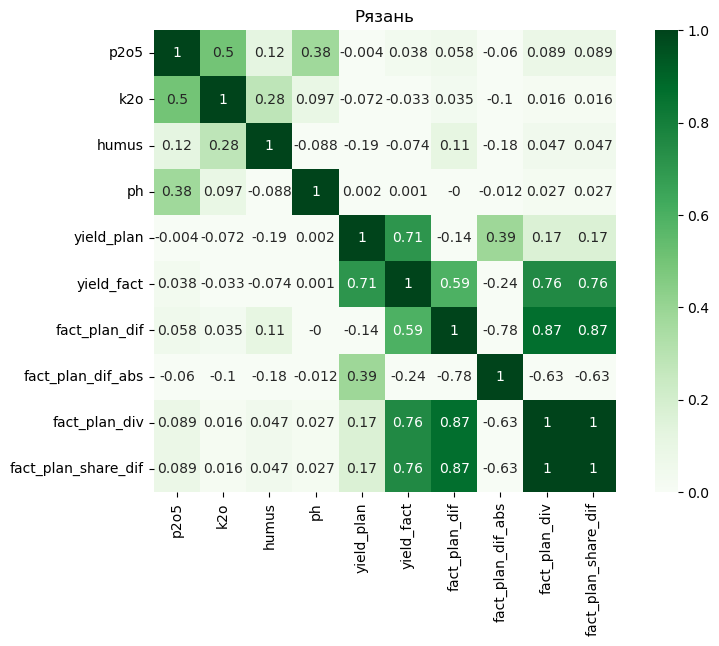

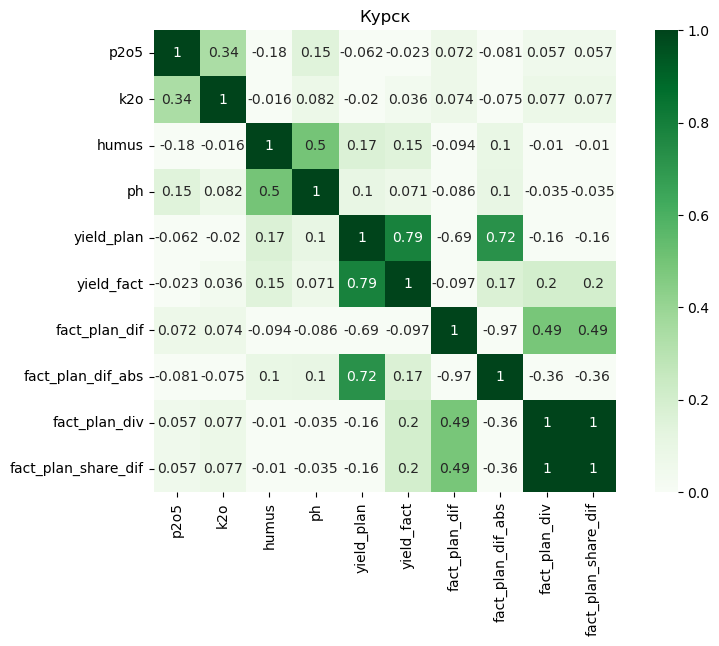

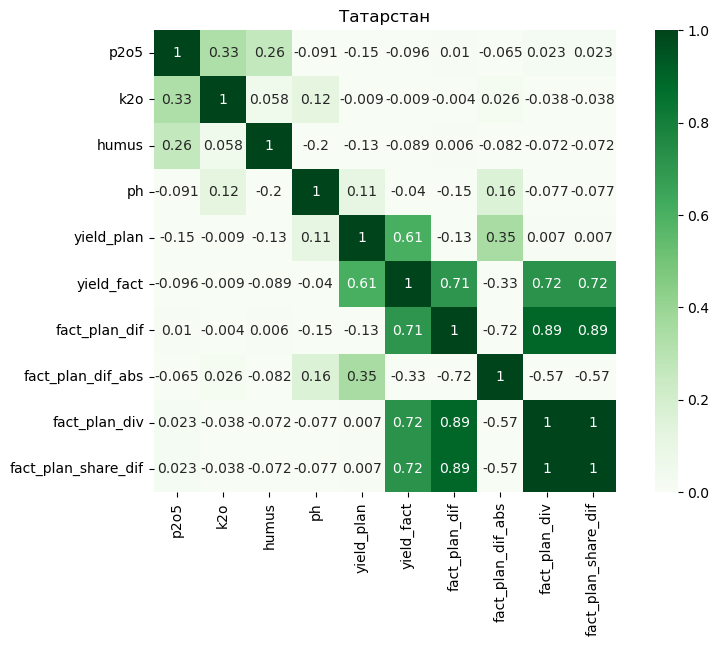

In [51]:
for region in top_regions:
    plt.figure(figsize=(10, 6))

    df_region = df.query(f"region == '{region}'")

    corrs = df_region.drop(['season', 'field', 'crop', 'region'], axis=1).corr().round(3)
    sns.heatmap(corrs,
                cmap = 'Greens',
                square=True,
                vmin = 0,
                annot=True)

    plt.title(f'{region}')
    plt.show()

plt.close()

In [53]:
df.to_csv('../data/fact_plan.csv', index=False)